# 05 - Density of StatesThis script calculates and plots the electronic density of states (DOS)for silicon, demonstrating both total DOS and atom-projected DOS.    python run.py

In [1]:
import numpy as np
from ase.build import bulk

from vasp import Vasp

# Try to import matplotlib for plotting
try:
    import matplotlib.pyplot as plt
    HAS_MATPLOTLIB = True
except ImportError:
    HAS_MATPLOTLIB = False
    print("Note: matplotlib not found. Plots will be skipped.")


## Step 1: Self-consistent calculation


In [2]:
print("=" * 60)
print("Density of States Calculation")
print("=" * 60)
print()

atoms = bulk('Si', 'diamond', a=5.43)

print("Step 1: Self-consistent ground state calculation")
print()

calc_scf = Vasp(
    label='results/dos/scf',
    atoms=atoms,
    xc='PBE',
    encut=400,
    kpts=(8, 8, 8),  # Dense k-grid for accurate DOS
    ismear=1,
    sigma=0.1,
    lwave=True,   # Need wavefunction for DOS
    lcharg=True,  # Need charge density
)

energy = calc_scf.potential_energy
print(f"  Total energy: {energy:.6f} eV")
print(f"  Fermi level: {calc_scf.results.get('fermi_level', 'N/A'):.4f} eV")
print()


Density of States Calculation

Step 1: Self-consistent ground state calculation

  Total energy: 4.020136 eV
  Fermi level: 5.8238 eV



## Step 2: DOS calculation (non-self-consistent)


In [3]:
print("Step 2: Non-self-consistent DOS calculation")
print()

calc_dos = Vasp(
    label='results/dos/dos',
    atoms=atoms,
    xc='PBE',
    encut=400,
    kpts=(12, 12, 12),  # Even denser grid for smooth DOS
    ismear=-5,          # Tetrahedron method for accurate DOS
    icharg=11,          # Read charge from previous calculation
    lorbit=11,          # Projected DOS with all quantum numbers
    nedos=2001,         # Number of DOS points

    # Reference the previous calculation
    lwave=False,
    lcharg=False,
)

# Copy charge density from SCF calculation
import os
import shutil

scf_dir = calc_scf.directory
dos_dir = calc_dos.directory
os.makedirs(dos_dir, exist_ok=True)

for f in ['CHGCAR', 'CHG']:
    src = os.path.join(scf_dir, f)
    dst = os.path.join(dos_dir, f)
    if os.path.exists(src):
        shutil.copy(src, dst)

energy_dos = calc_dos.potential_energy
print("  Calculation complete")
print()


Step 2: Non-self-consistent DOS calculation

  Calculation complete



## Step 3: Read and analyze DOS


In [4]:
print("Step 3: Reading DOS data")
print()

dos_data = calc_dos.read_doscar()

energy_grid = dos_data['energy']
total_dos = dos_data['total_dos']
fermi = dos_data['fermi']

print(f"  Energy range: {energy_grid[0]:.2f} to {energy_grid[-1]:.2f} eV")
print(f"  Fermi level: {fermi:.4f} eV")
print(f"  Number of points: {len(energy_grid)}")
print()

# Calculate band gap from DOS
band_gap = calc_dos.get_band_gap_from_doscar(tol=0.1)
print(f"  Band gap (from DOS): {band_gap:.3f} eV")
print("  Experimental band gap: 1.12 eV")
print("  Note: DFT-PBE underestimates band gaps")
print()


Step 3: Reading DOS data

  Energy range: -7.20 to 16.76 eV
  Fermi level: 6.4849 eV
  Number of points: 2001

  Band gap (from DOS): 0.839 eV
  Experimental band gap: 1.12 eV
  Note: DFT-PBE underestimates band gaps



/home/jovyan/vasp/vasp/mixins/analysis.py:406: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  projected.append(np.array(atom_dos))


## Step 4: Plot DOS


/tmp/ipykernel_5922/2147365208.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pdos = np.array(dos_data['projected'])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved plot: silicon_dos.png

DOS calculation complete!

Key points:
  - Use dense k-grids for smooth DOS
  - Tetrahedron method (ISMEAR=-5) gives best DOS
  - LORBIT=11 enables atom and orbital projections
  - PBE underestimates band gaps (use HSE06 for accuracy)

Next: Try 06_band_structure/ to plot band structure along k-paths.


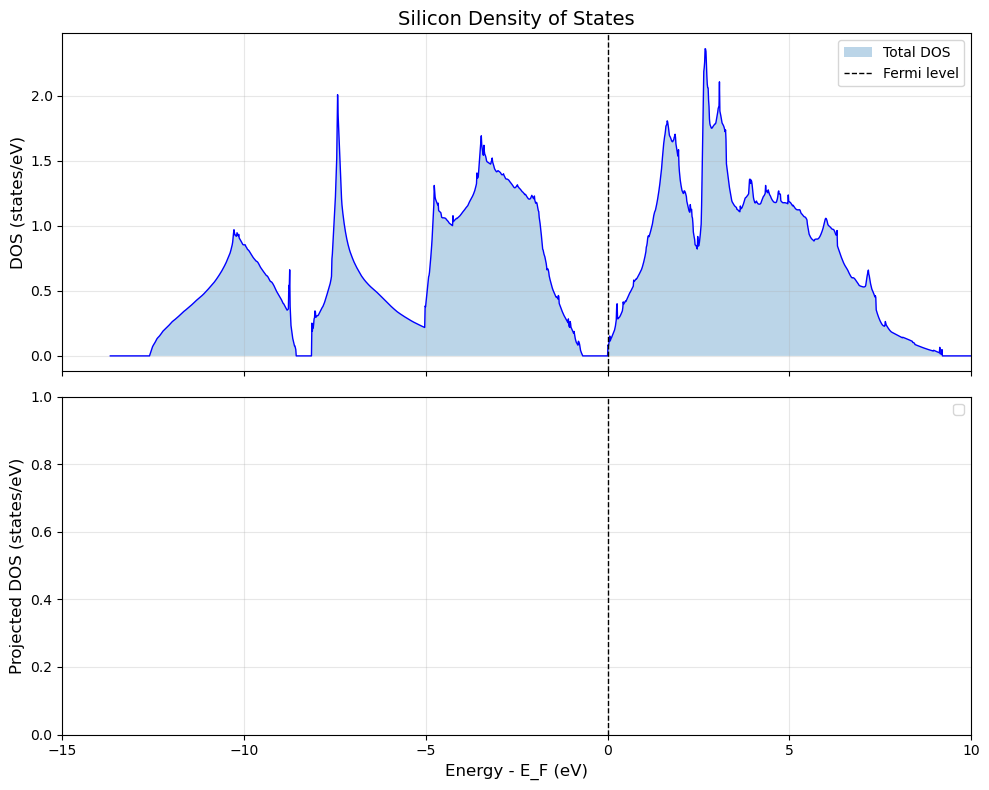

In [5]:
if HAS_MATPLOTLIB:
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Shift energy to Fermi level
    e_shifted = energy_grid - fermi

    # Plot total DOS
    ax1 = axes[0]
    ax1.fill_between(e_shifted, 0, total_dos, alpha=0.3, label='results/Total DOS')
    ax1.plot(e_shifted, total_dos, 'b-', linewidth=1)
    ax1.axvline(x=0, color='k', linestyle='--', linewidth=1, label='results/Fermi level')
    ax1.set_ylabel('DOS (states/eV)', fontsize=12)
    ax1.set_title('Silicon Density of States', fontsize=14)
    ax1.legend(loc='upper right')
    ax1.set_xlim(-15, 10)
    ax1.grid(True, alpha=0.3)

    # Plot projected DOS if available
    ax2 = axes[1]
    if 'projected' in dos_data and dos_data['projected']:
        # Sum over all atoms
        pdos = np.array(dos_data['projected'])
        if len(pdos.shape) == 3:
            # Shape: (natoms, nedos, norbitals)
            pdos_sum = pdos.sum(axis=0)  # Sum over atoms

            # LORBIT=11 gives: s, py, pz, px, dxy, dyz, dz2, dxz, dx2-y2
            # Simplified: just plot s and p
            if pdos_sum.shape[1] >= 4:
                s_dos = pdos_sum[:, 0]
                p_dos = pdos_sum[:, 1:4].sum(axis=1)

                ax2.fill_between(e_shifted, 0, s_dos, alpha=0.3, label='results/s')
                ax2.fill_between(e_shifted, 0, p_dos, alpha=0.3, label='results/p')
                ax2.plot(e_shifted, s_dos, 'b-', linewidth=1)
                ax2.plot(e_shifted, p_dos, 'r-', linewidth=1)
        ax2.axvline(x=0, color='k', linestyle='--', linewidth=1)
        ax2.set_ylabel('Projected DOS (states/eV)', fontsize=12)
        ax2.legend(loc='upper right')
    else:
        ax2.text(0.5, 0.5, 'Projected DOS not available\n(requires LORBIT=11)',
                transform=ax2.transAxes, ha='center', va='center')

    ax2.set_xlabel('Energy - E_F (eV)', fontsize=12)
    ax2.set_xlim(-15, 10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('silicon_dos.png', dpi=150)
    print("Saved plot: silicon_dos.png")

print()
print("=" * 60)
print("DOS calculation complete!")
print("=" * 60)
print()
print("Key points:")
print("  - Use dense k-grids for smooth DOS")
print("  - Tetrahedron method (ISMEAR=-5) gives best DOS")
print("  - LORBIT=11 enables atom and orbital projections")
print("  - PBE underestimates band gaps (use HSE06 for accuracy)")
print()
print("Next: Try 06_band_structure/ to plot band structure along k-paths.")
